In [16]:
from options import Options
from grid import Grid
from trajectory_generator import generate_trajectory
import torch
import numpy as np
import plotting
import analysis
import os
%load_ext autoreload
import utils
import matplotlib.pyplot as plt
%autoreload 2

sim_path = os.getcwd() + '/sim_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Build and intiialize network

In [7]:
options = Options()
options.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device :', options.device)
grid = Grid(options)

device : cuda
Recovering pre-computed matrix found at /home/onyxia/work/grid_cells_burak_fiete/models/Wmat_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40.pth
Restoring pre-computed initial state found at /home/onyxia/work/grid_cells_burak_fiete/models/s0_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40_tau=0.01_alpha=0.2_tiling=deterministic_device=cuda_solver=euler_dt=0.0001.pth


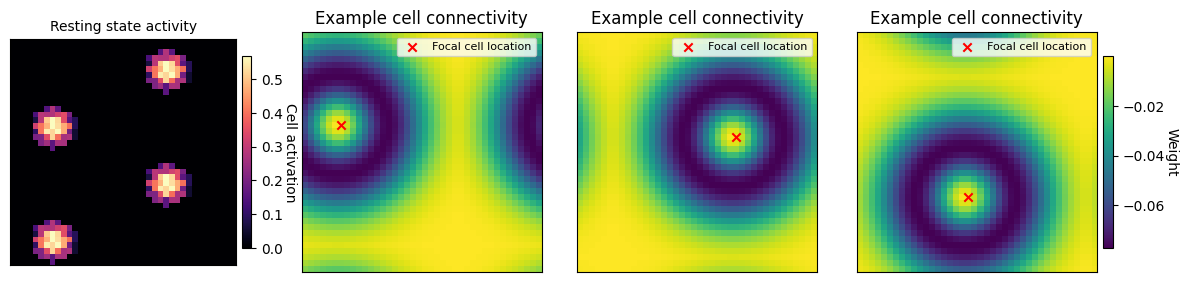

In [8]:
_ = plotting.network_presentation(grid)

### 2. Integrate random trajectory

Found pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/trajectory_len=10000_dt=0.0001_w=2.2_h=2.2_rotvelstd=1.6_meanv=0.8_border=0.03_borderslow=0.25.npy, loading it
loading pre-computed trajectory at example_sim_T=1_dt=0.0001_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40_tau=0.01_alpha=0.2_tiling=deterministic_device=cuda_solver=euler_dt=0.0001.pth
labeling blobs


100%|██████████| 9999/9999 [00:00<00:00, 17352.67it/s]


detected less than 8 blobs per frame
computing blob centers


/opt/conda/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
100%|██████████| 9999/9999 [00:01<00:00, 6251.97it/s]


found 3 best blob jumps : interpolating speed between them
Estimated prediction to truth size ratio = 0.0667, R2=1.0


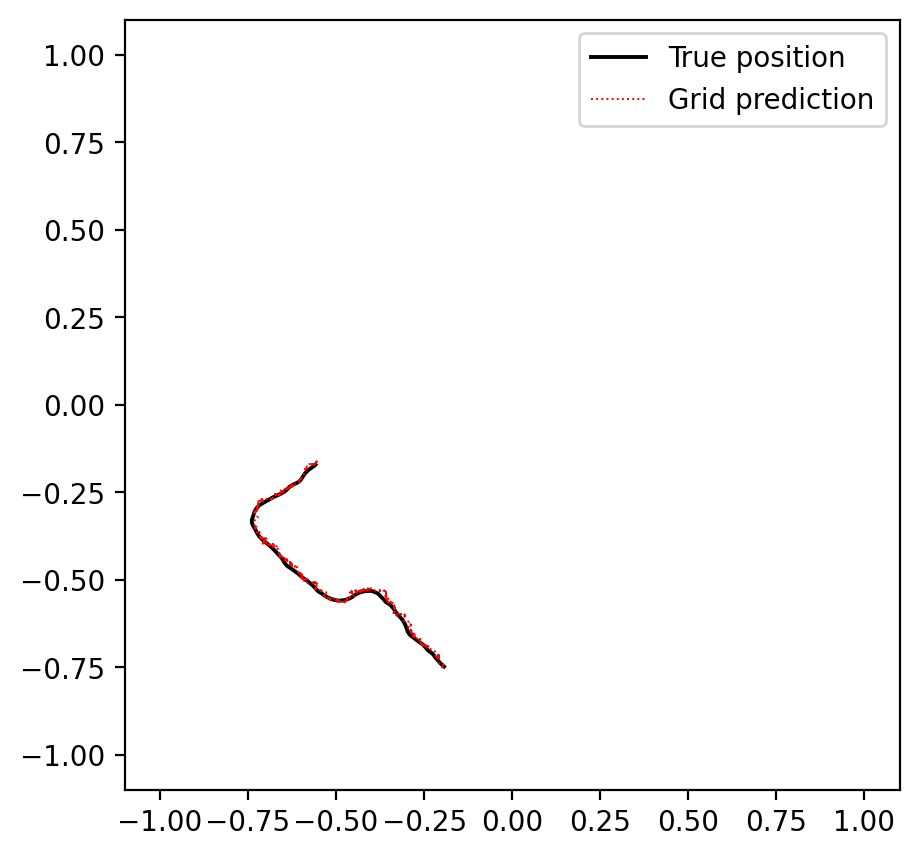

In [22]:
# generate a trajectory 
box_width = box_height = 2.2 # m 
T = 1 # s
dt = grid.options.dt
seq_len = int(T/dt)


trajectory = generate_trajectory(box_width, box_height, seq_len, load=True, save=True, batch_size = 1, silent=False)

torch.cuda.empty_cache()

pos = np.stack([trajectory['target_x'].squeeze(), trajectory['target_y'].squeeze()], 1)

v_inputs = np.diff(pos, axis=0)/dt

fname = f"example_sim_T={T}_dt={dt}_{grid.grid_id}.pth"


load = True # set to false to restart a new sim from scratch

if os.path.exists(sim_path + fname):
    print(f"loading pre-computed trajectory at {fname}")
    S= torch.load(sim_path + fname, weights_only = True)
else:
    grid.save_sim = True
    S = grid.simulate(v_inputs, sim_id = fname, silent=False)


# downsample if needed for faster analysis
new_dt = 1E-4
S = utils.downsample(S, new_dt=new_dt, old_dt = dt)
pos = utils.downsample(pos, new_dt=new_dt, old_dt = dt)

pos_pred, prop_factor, r2 = analysis.model_prediction(S, pos, verb = True)

fig, ax = plt.subplots(figsize=(5, 5), dpi = 200)
kw = {'c': 'black', 'ls': '-', 'lw':1.4, 'label':'True position'}
ax = plotting.plot_trajectory(*pos.T, box_width = box_width, box_height = box_height,ax=ax, show=False, plot_kwargs=kw)
kw = {'c': 'red', 'ls': ':', 'lw':0.7, 'label':'Grid prediction'}
ax = plotting.plot_trajectory(*pos_pred.T, box_width = box_width, box_height = box_height,ax=ax, show=False, plot_kwargs=kw)
plt.legend()
plt.show()

### Idées pour la suite :

- Entrainer un RNN (approche normative/optimale) cf https://github.com/ganguli-lab/grid-pattern-formation (publié sur Neuron, j'ai testé un peu l'approche et ca fonctionne, suffit de reprendre leur code ou de recoder une version + simple) => Comparer le résultat du RNN et du modele de burak

- Regarder la topologie du réseau (topologie torique ?) -> reduction de la dimensionalité de la matrice de connectivité et / ou de l'activité neuronale. Comparer eventuellement avec le RNN 